# Sprint　機械学習スクラッチ　決定木  
＜目的＞  
- スクラッチを通して決定木を理解する
- 複雑なアルゴリズムの実装に慣れる

分類のための決定木のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。  
決定木の学習には何回まで条件分岐を繰り返すかを表す （最大の）深さ というハイパーパラメータが登場しますが、深さ1の実装を必須課題とします。深さが2以上のものはアドバンス課題とします。  
学習の仕方には様々な方法がありますが、ここではscikit-learnでも使用されている CART法 をベースとした実装を行います。この方法では学習の複雑さを減らすために、 分岐は2つに分かれるのみ になります。  
以下に雛形を用意してあります。このScratchDecesionTreeClassifierDepth1クラスにコードを書き加えていってください。

### 【問題1】不純度を求める関数  
ノード の ジニ不純度 を計算する関数を作成してください。ノード $t$ に対するジニ不純度 $I(t)$ は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。

$$
I(t)=1-\sum_{i=1}^{K}P^2(C_i|t)=1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,al}})^2=\sum_{i=1}^{K}P(C_i|t)(1-P(C_i|t))
$$

$t$ : ノードのインデックス  
$i$ : クラスのインデックス  
$K$ : クラスの数  
$C_i$ : i番目のクラス  
$P(C_i|t)$ :　t番目のノードにおける$C_i$の割合  
$N_{t,i}$ : t番目のノードのi番目のクラスに属するサンプル数  
$N_{t,all}$ : t番目のノードのサンプルの総数  

まずは簡単な例を作り、手計算と関数の結果を比較してください。

《例》
- クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
- クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
- クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
- クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn import metrics 

In [2]:
def _gini(y):
    element, count = np.unique(y, return_counts=True)
    g = 0
    for i in range(len(element)):
        g += (count[i]/len(y))**2
    return 1 - g

In [3]:
# 例の確認
y_1 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
print(_gini(y_1))

y_2 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                2,2,2,2,2,2,2,2,2,2,2,2,2,2,2])
print(_gini(y_2))

y_3 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                1,1,1,1,1,1,1,1,1,1,1,1])
print(_gini(y_3))

y_4 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
print(_gini(y_4))

0.5
0.6666666666666667
0.48
0.0


### 【問題2】情報利得を求める関数  
次に、ノード間の 情報利得 を計算する関数を作成してください。問題1で作成したジニ不純度 $I(t)$ を計算する関数を呼び出して使います。情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。  
ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。

$$
IG(p)=I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)
$$

$p$ : 親ノードを示すインデックス  
$left$ : 左側のノードを示すインデックス  
$right$ : 右側のノードを示すインデックス  

まずは簡単な例を作り、手計算と関数の結果を比較してください。

《例》  
左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.143

In [4]:
def _info_gain(y, y_1, y_2):
    gini_p = _gini(y)
    gini_1 = _gini(y_1)*len(y_1)/len(y)
    gini_2 = _gini(y_2)*len(y_2)/len(y)
    return gini_p - gini_1 - gini_2

In [5]:
# 例の確認
y_1 = np.array([0,0,0,0,0,0,0,0,0,0,
                1,1,1,1,1,1,1,1,1,1,
                1,1,1,1,1,1,1,1,1,1,
                1,1,1,1,1,1,1,1,1,1])
y_2 = np.array([0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,
                1,1,1,1,1])
y_p = np.array([0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,
                1,1,1,1,1,1,1,1,1,1,
                1,1,1,1,1,1,1,1,1,1,
                1,1,1,1,1,1,1,1,1,1,
                1,1,1,1,1])
_info_gain(y_p, y_1, y_2)

0.14319526627218937

### 【問題3】学習    
空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。  
訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。  
クラスが混ざらない不純度が0のノード、または指定された深さのノードが **葉ノード** となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。

**《組み合わせの取り方》**  
全ての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。片側の端は今回のスクラッチはこの方法で行なってください。  
他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。

**《補足》**  
問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度 $I(p)$ は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。

### 【問題4】推定  
推定する仕組みを実装してください。ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。  
入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。葉ノードにはクラスが記録されているので、これが推定値となります。

In [6]:
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    min_samples_split=2
      分割されるサンプル数の最小値
      
    Attributes
    ----------
    self.feature : int
      決定木を適用する特徴量のインデックス
    self.threshold : float
      上記の特徴量の閾値
    self.label_1 : float
    　決定木による分割のラベル
    self.label_2 : float
    　決定木による分割のラベル
    """
    
    def __init__(self, min_samples_split=2, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        self.min_samples_split = min_samples_split
        
    def _gini(self, y):
        element, count = np.unique(y, return_counts=True)
        g = 0
        for i in range(len(element)):
            g += (count[i]/len(y))**2
        return 1 - g
    
    def _info_gain(self, y, y_1, y_2):
        gini_p = self._gini(y)
        gini_1 = self._gini(y_1)*len(y_1)/len(y)
        gini_2 = self._gini(y_2)*len(y_2)/len(y)
        return gini_p - gini_1 - gini_2
    
    def _make_tree(self, X, y):
        self.IGs = [0]
        IG = 0
        feature = None
        threshold = None
        # 特徴量のループ
        for i in range(X.shape[1]):
            # 値の重複を避けるためnp.uniqueに通す
            values = np.unique(X[:, i])
            # サンプルのループ
            for j in range(len(values)):
                indices_1 = list(np.where(X[:, i] >= values[j])[0])
                indices_2 = list(np.where(X[:, i] < values[j])[0])
                # 片方のノードは、最低2つのサンプルを保持する
                # sklearnのdefault設定に合わせて
                if len(indices_1) <= self.min_samples_split - 1 or len(indices_2) <= self.min_samples_split - 1:
                    pass
                else:
                    IG = self._info_gain(y, y[indices_1], y[indices_2])
                    # IGが最大なら、特徴量と閾値を更新
                    if IG >= max(self.IGs):
                        feature, threshold = i, values[j]
                # IGの推移を格納
                self.IGs.append(IG)
        return feature, threshold
    
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        self.feature, self.threshold = self._make_tree(X, y)
        # 分割されたラベルの多数決でラベルを出力
        y_1 = y[X[:, self.feature] >= self.threshold].astype(int)
        y_2 = y[X[:, self.feature] < self.threshold].astype(int)
        self.label_1 = np.argmax(np.bincount(y_1))
        self.label_2 = np.argmax(np.bincount(y_2))
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('infomation gain : {}'.format(self.IGs))

    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        return np.where(X[:, self.feature] >= self.threshold, self.label_1, self.label_2)

### 【問題5】学習と推定  
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。  
scikit-learnによる実装と比べ、正しく動いているかを確認してください。  
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

### 【問題6】決定領域の可視化
決定領域を可視化してください。

In [7]:
# シンプルデータセット2
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

y = y[:, np.newaxis]
data = np.hstack([X, y])
df_2 = pd.DataFrame(data, columns=['f0', 'f1', 'class'])
print('< Sample 2 >')
display(df_2.head())
display(np.shape(df_2))
display(df_2.describe())

< Sample 2 >


,f0,f1,class
0,-0.44699,-2.8073,0.0
1,-1.46210,-2.4586,0.0
2,0.10645,1.9242,0.0
3,-3.59440,-4.0112,0.0
4,-0.98880,4.5718,0.0


(40, 3)

,f0,f1,class
count,40.000000,40.000000,40.00000
mean,-0.957180,2.175311,0.50000
std,1.806803,5.020648,0.50637
min,-6.679700,-4.353000,0.00000
25%,-2.263750,-1.919800,0.00000
50%,-0.607335,0.702745,0.50000
75%,0.550628,5.381325,1.00000
max,1.477100,15.682400,1.00000


In [8]:
# 前処理
X = df_2.iloc[:, :-1].values
y = df_2.iloc[:, -1].values

# 訓練/検証データに3:1で分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=1)

print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(30, 2)
(10, 2)
(30,)
(10,)


In [9]:
# 決定境界描画関数
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['0', '1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, n_features)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [10]:
# 評価関数
def evaluate(y_true, y_pred):
    """
    2値分類の評価指標を計算する
    """
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    return acc, precision, recall, f1, confusion

=== Decision Tree Classifier (scikit-learn) ===

< max_depth : 1, min_samples_split : 2 >

Decision Region(train/validation)


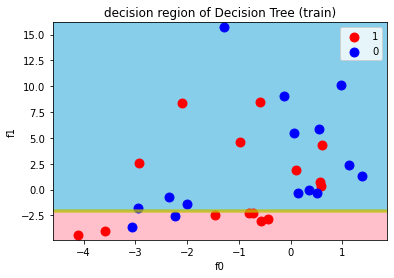

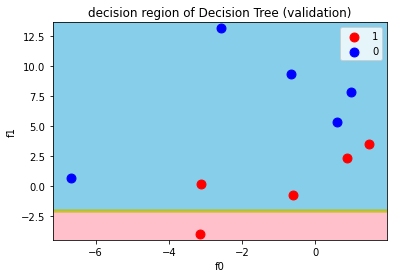

Accuracy : 0.600
Precision : 0.556
Recall : 1.000
F1 : 0.714
confusion matrix 
 [[1 4]
 [0 5]]



In [11]:
# sklearn
print("=== Decision Tree Classifier (scikit-learn) ===\n")
print("< max_depth : 1, min_samples_split : 2 >\n")

# 学習・推論
tree_1 = DecisionTreeClassifier(max_depth=1, min_samples_split=2)
tree_1.fit(X_train, y_train)
y_pred = tree_1.predict(X_test)
        
# 可視化
print('Decision Region(train/validation)')
decision_region(X_train, y_train.flatten(), tree_1, 
                title="decision region of Decision Tree (train)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])
decision_region(X_test, y_test.flatten(), tree_1, 
                title="decision region of Decision Tree (validation)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

=== Decision Tree Classifier (Scratch) ===

< max_depth : 1, min_samples_split : 2 >

Decision Resion(train/validation)


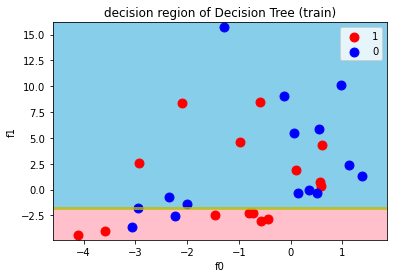

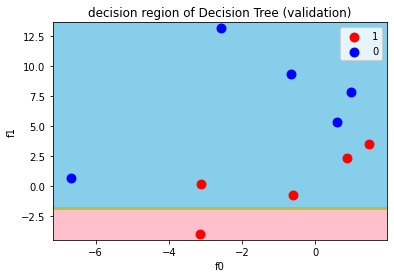

Accuracy : 0.600
Precision : 0.556
Recall : 1.000
F1 : 0.714
confusion matrix 
 [[1 4]
 [0 5]]



In [12]:
# Scratch
print("=== Decision Tree Classifier (Scratch) ===\n")
print("< max_depth : 1, min_samples_split : 2 >\n")

# 学習・推論 
stree_1 = ScratchDecesionTreeClassifierDepth1(verbose=False)
stree_1.fit(X_train, y_train)
y_pred = stree_1.predict(X_test)
        
# 可視化
print('Decision Resion(train/validation)')
decision_region(X_train, y_train.flatten(), stree_1, 
                title="decision region of Decision Tree (train)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])
decision_region(X_test, y_test.flatten(), stree_1, 
                title="decision region of Decision Tree (validation)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

- sklearnと比較し、ほぼ同じような挙動のようだ

In [13]:
# 情報利得のプロット
def plot_IGs(n_iter, IGs):
    plt.plot(np.arange(n_iter), IGs, label='IG')
    plt.title('information gain')
    plt.xlabel('iter')
    plt.ylabel('IG')
    plt.legend()
    plt.show()

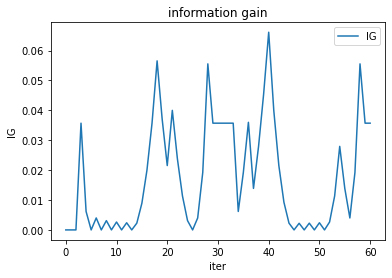

In [14]:
 plot_IGs(len(stree_1.IGs), stree_1.IGs)

### 【問題7】深さ2の決定木分類器クラスの作成  
深さが2の決定木分類器のクラスScratchDecesionTreeClassifierDepth2を作成してください。  
深さ2とは空間の分割を2回行うことを指します。 

《ヒント》  
各ノードをインスタンスとして扱うと、任意の深さへの拡張が行いやすくなります。

### 【問題8】深さに制限のない決定木分類器クラスの作成  
深さに制限のない決定木分類器のクラスScratchDecesionTreeClassifierDepthInfを作成してください。  
任意の深さを指定できるようにするとともに、指定しない場合は全ての葉ノードがジニ不純度0となるまで続けられるようにもしてください。

### ＜方針＞  
- 深さに制限のない決定木クラスを作成し、深さ2を含めmax_depthで調節できるようにする
- 決定木クラスの他にNodeクラスを作成し、再帰的に使用できるようにする方針

In [15]:
class ScratchDecesionTreeClassifierDepthInf():
    """
    深さの制限のない決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    max_depth : int
      決定木の深さの最大値
    min_samples_split=2
      分割時のサンプル数の最小値
      
    Attributes
    ----------
    self.tree : object
      決定木の学習器
    
    """
    
    def __init__(self, max_depth=-1, min_samples_split=2, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
             訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        # 最大指定の場合、max_depthはサンプル数とする
        if self.max_depth == -1:
            self.max_depth = X.shape[0]
        
        self.tree = Node(self.max_depth, self.verbose)
        # 深さ1からノードを分岐していく
        self.tree._split(X, y, depth=1)
        
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        pred = []
        # ノードによって入力のサイズが違うため、1サンプルずつ推定
        for i in range(X.shape[0]):
            x = X[i, :]
            pred.append(self.tree._predict(x))
        return np.array(pred)

In [16]:
class Node():
    """
    決定木分類器内のノード実装
    
    Parameters
    ----------
    max_depth : int
      木の深さの最大値
　　min_samples_split : int
      分割されるサンプル数の最小値
    verbose : bool
     学習過程を出力する場合はTrue
  
    Attributes
    ----------
    self.feature : int
      分割を適用する特徴量のインデックス
    self.threshold : float
      上記の特徴量の閾値
    self.depth : int
      ノードが位置する深さ
    self.right_leaf : bool
      ノードの右が葉かどうかのフラグ
    self.left_leaf = False
    　ノードの左が葉かどうかのフラグ
    self.label_1 : float
      ノードの右が葉の場合の出力ラベル
    self.label_2 : float
      ノードの左が葉の場合の出力ラベル
    """
    
    def __init__(self, max_depth, min_samples_split=2, verbose=False):
        self.max_depth = max_depth
        self.min_samples_split=min_samples_split
        self.depth = None
        self.feature = None
        self.threshold = None
        self.right_leaf = False
        self.left_leaf = False
        self.verbose = verbose
    
    def _gini(self, y):
        element, count = np.unique(y, return_counts=True)
        g = 0
        for i in range(len(element)):
            g += (count[i]/len(y))**2
        return 1 - g

    def _info_gain(self, y, y_1, y_2):
        gini_p = self._gini(y)
        gini_1 = self._gini(y_1)*len(y_1)/len(y)
        gini_2 = self._gini(y_2)*len(y_2)/len(y)
        return gini_p - gini_1 - gini_2
 
    def _make_tree(self, X, y):
        self.IGs = [0]
        IG = 0
        for i in range(X.shape[1]):
            values = np.unique(X[:, i])
            for j in range(len(values)):
                indices_1 = list(np.where(X[:, i] >= values[j])[0])
                indices_2 = list(np.where(X[:, i] < values[j])[0])
                if len(indices_1) <= self.min_samples_split - 1 or len(indices_2) <= self.min_samples_split - 1:
                    IG = 0
                else:
                    IG = self._info_gain(y, y[indices_1], y[indices_2])
                    if IG >= max(self.IGs):
                        feature, threshold = i, values[j]
                self.IGs.append(IG)
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('depth : {}'.format(self.depth))
            print('infomation gain : {}'.format(self.IGs))
        return feature, threshold

    def _split(self, X, y, depth):
        """
        決定木を学習し伸ばす
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        depth : int
            ノードが位置する深さ
        """
        self.depth = depth
        self.feature, self.threshold = self._make_tree(X, y)
        # 受け取ったデータを条件で分割
        X_1 = X[X[:, self.feature] >= self.threshold]
        y_1 = y[X[:, self.feature] >= self.threshold].astype(int)
        X_2 = X[X[:, self.feature] < self.threshold]
        y_2 = y[X[:, self.feature] < self.threshold].astype(int)
        # 左右のラベルを多数決で決定
        self.label_1 = np.argmax(np.bincount(y_1))
        self.label_2 = np.argmax(np.bincount(y_2))
        
        # 最底層に達している場合は、左右を葉にする
        if self.depth == self.max_depth:
            self.right_leaf = True
            self.left_leaf = True
        else:
            # 不純度が0の場合は葉に、でなければ1つ下の深さにノードを生成
            if len(np.unique(y_1)) == 1:
                self.right_leaf = True
            else:
                self.right_leaf = Node(self.max_depth, self.verbose)
                self.right_leaf._split(X_1, y_1, self.depth + 1)
            if len(np.unique(y_2)) == 1:
                self.left_leaf = True
            else:
                self.left_leaf = Node(self.max_depth, self.verbose)
                self.left_leaf._split(X_2, y_2, self.depth + 1)
        
    def _predict(self, x):
        """
        葉を使いラベルを推定する。葉でない場合は次のノードへ渡す。
        """
        # 受け取るのは1サンプル
        # 特徴量条件により左右の出力に割り当てる
        # 葉ならば該当ラベルを出力、でなければ次のノードに予測を依頼
        if x[self.feature] >= self.threshold:
            if self.right_leaf == True:
                output = self.label_1
            else:
                output = self.right_leaf._predict(x)
        else:
            if self.left_leaf == True:
                output= self.label_2
            else:
                output = self.left_leaf._predict(x)
        return output

### 1. 深さ2の決定木

=== Decision Tree Classifier (scikit-learn) ===

< max_depth : 2, min_samples_split : 2 >

Decision Region(train/validation)


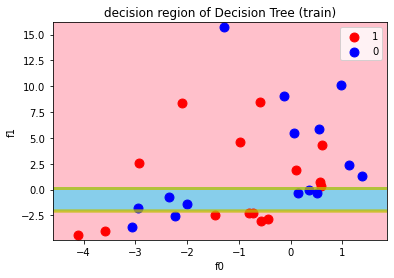

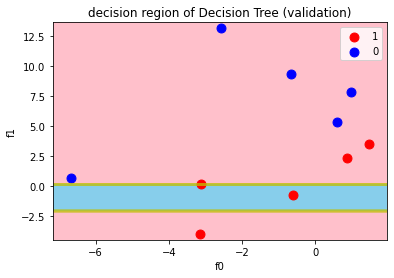

Accuracy : 0.300
Precision : 0.000
Recall : 0.000
F1 : 0.000
confusion matrix 
 [[3 2]
 [5 0]]



In [17]:
# sklearn
print("=== Decision Tree Classifier (scikit-learn) ===\n")
print("< max_depth : 2, min_samples_split : 2 >\n")

# 学習・推論
tree_2 = DecisionTreeClassifier(max_depth=2, min_samples_split=2)
tree_2.fit(X_train, y_train)
y_pred = tree_2.predict(X_test)
        
# 可視化
print('Decision Region(train/validation)')
decision_region(X_train, y_train.flatten(), tree_2, 
                title="decision region of Decision Tree (train)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])
decision_region(X_test, y_test.flatten(), tree_2, 
                title="decision region of Decision Tree (validation)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

=== Decision Tree Classifier (Scratch) ===

< max_depth : 2, min_samples_split : 2 >

Decision Resion(train/validation)


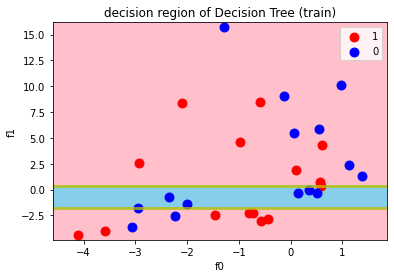

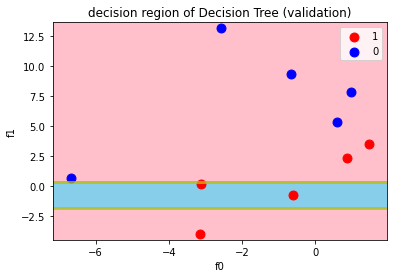

Accuracy : 0.300
Precision : 0.000
Recall : 0.000
F1 : 0.000
confusion matrix 
 [[3 2]
 [5 0]]



In [18]:
# Scratch
print("=== Decision Tree Classifier (Scratch) ===\n")
print("< max_depth : 2, min_samples_split : 2 >\n")

# 学習・推論 
stree_2 = ScratchDecesionTreeClassifierDepthInf(max_depth=2, min_samples_split=2)
stree_2.fit(X_train, y_train)
y_pred = stree_2.predict(X_test)
        
# 可視化
print('Decision Resion(train/validation)')
decision_region(X_train, y_train.flatten(), stree_2, 
                title="decision region of Decision Tree (train)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])
decision_region(X_test, y_test.flatten(), stree_2, 
                title="decision region of Decision Tree (validation)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

### 2. 深さ3の決定木

=== Decision Tree Classifier (scikit-learn) ===

< max_depth : 3, min_samples_split : 2 >

Decision Region(train/validation)


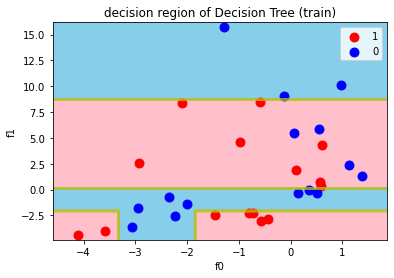

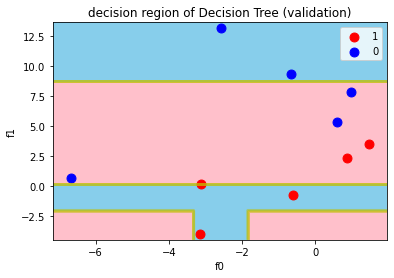

Accuracy : 0.400
Precision : 0.400
Recall : 0.400
F1 : 0.400
confusion matrix 
 [[2 3]
 [3 2]]



In [19]:
# sklearn
print("=== Decision Tree Classifier (scikit-learn) ===\n")
print("< max_depth : 3, min_samples_split : 2 >\n")

# 学習・推論
tree_3 = DecisionTreeClassifier(max_depth=3, min_samples_split=2)
tree_3.fit(X_train, y_train)
y_pred = tree_3.predict(X_test)
        
# 可視化
print('Decision Region(train/validation)')
decision_region(X_train, y_train.flatten(), tree_3, 
                title="decision region of Decision Tree (train)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])
decision_region(X_test, y_test.flatten(), tree_3, 
                title="decision region of Decision Tree (validation)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

=== Decision Tree Classifier (Scratch) ===

< max_depth : 3, min_samples_split : 2 >

Decision Resion(train/validation)


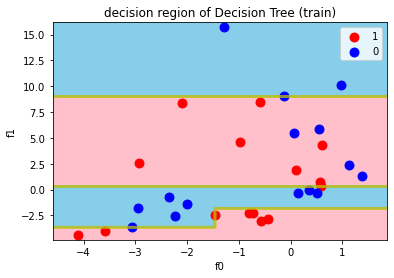

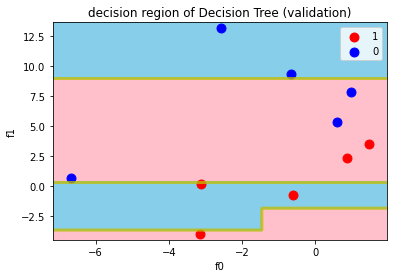

Accuracy : 0.500
Precision : 0.500
Recall : 0.400
F1 : 0.444
confusion matrix 
 [[3 2]
 [3 2]]



In [20]:
# Scratch
print("=== Decision Tree Classifier (Scratch) ===\n")
print("< max_depth : 3, min_samples_split : 2 >\n")

# 学習・推論 
stree_3 = ScratchDecesionTreeClassifierDepthInf(max_depth=3, min_samples_split=2,)
stree_3.fit(X_train, y_train)
y_pred = stree_3.predict(X_test)
        
# 可視化
print('Decision Resion(train/validation)')
decision_region(X_train, y_train.flatten(), stree_3, 
                title="decision region of Decision Tree (train)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])
decision_region(X_test, y_test.flatten(), stree_3, 
                title="decision region of Decision Tree (validation)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

### 3. 深さ無限の決定木

=== Decision Tree Classifier (scikit-learn) ===

< max_depth : ∞, min_samples_split : 2 >

Decision Region(train/validation)


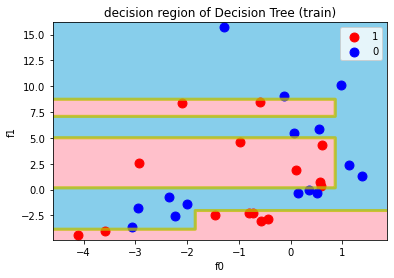

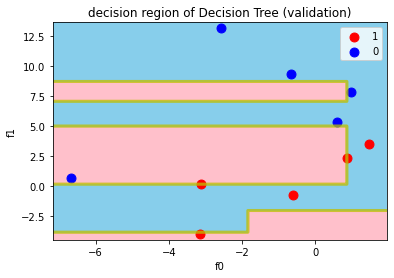

Accuracy : 0.600
Precision : 0.571
Recall : 0.800
F1 : 0.667
confusion matrix 
 [[2 3]
 [1 4]]



In [21]:
# sklearn
print("=== Decision Tree Classifier (scikit-learn) ===\n")
print("< max_depth : ∞, min_samples_split : 2 >\n")

# 学習・推論
tree_inf = DecisionTreeClassifier(min_samples_split=2)
tree_inf.fit(X_train, y_train)
y_pred = tree_inf.predict(X_test)
        
# 可視化
print('Decision Region(train/validation)')
decision_region(X_train, y_train.flatten(), tree_inf, 
                title="decision region of Decision Tree (train)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])
decision_region(X_test, y_test.flatten(), tree_inf, 
                title="decision region of Decision Tree (validation)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

=== Decision Tree Classifier (Scratch) ===

< max_depth : ∞, min_samples_split : 2 >

Decision Resion(train/validation)


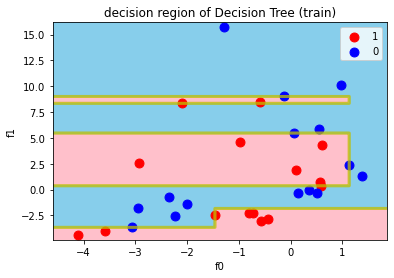

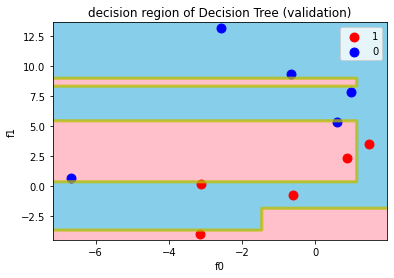

Accuracy : 0.500
Precision : 0.500
Recall : 0.600
F1 : 0.545
confusion matrix 
 [[2 3]
 [2 3]]



In [22]:
# Scratch
print("=== Decision Tree Classifier (Scratch) ===\n")
print("< max_depth : ∞, min_samples_split : 2 >\n")

# 学習・推論 
stree_inf = ScratchDecesionTreeClassifierDepthInf(max_depth=-1, min_samples_split=2,)
stree_inf.fit(X_train, y_train)
y_pred = stree_inf.predict(X_test)
        
# 可視化
print('Decision Resion(train/validation)')
decision_region(X_train, y_train.flatten(), stree_inf, 
                title="decision region of Decision Tree (train)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])
decision_region(X_test, y_test.flatten(), stree_inf, 
                title="decision region of Decision Tree (validation)",
                xlabel='f0', ylabel='f1', target_names=['1', '0'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

- sklearnとは決定境界が微妙に異なるが、大筋は一致しているようだ
- 深さ無限大でtrainデータを完全に分離できており、意図した挙動はしているようだ